<a href="https://colab.research.google.com/github/nid-22/CNN_melonoma_detection/blob/main/Assignment_CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
Take necessary actions to read the data

### Importing all the important libraries

In [30]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

In [31]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [32]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Test')

In [33]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2198
12


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [34]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [35]:
## Write your train dataset here
train_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size, image_size=(img_width,img_height), label_mode='categorical',seed=123)



Found 6698 files belonging to 9 classes.


In [36]:

val_ds = keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=batch_size, image_size=(img_width,img_height), label_mode='categorical',seed=123)

Found 12 files belonging to 9 classes.


In [37]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### code to visualize one instance of all the nine classes present in the dataset

In [38]:
# make a dict to store all pathnames in this format
# 'pigmented benign keratosis': ['/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0024435.jpg',
#   '/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0024445.jpg',

class_to_img_dict = {}
for class_ in class_names:
    class_to_img_dict[class_] = [(str(data_dir_train) + '/' + class_+ '/' +img) for img in os.listdir(str(data_dir_train) + '/' + class_)]


In [39]:
for k,v in class_to_img_dict.items():
    print(k, len(v))

actinic keratosis 115
basal cell carcinoma 377
dermatofibroma 191
melanoma 439
nevus 222
pigmented benign keratosis 463
seborrheic keratosis 78
squamous cell carcinoma 182
vascular lesion 140


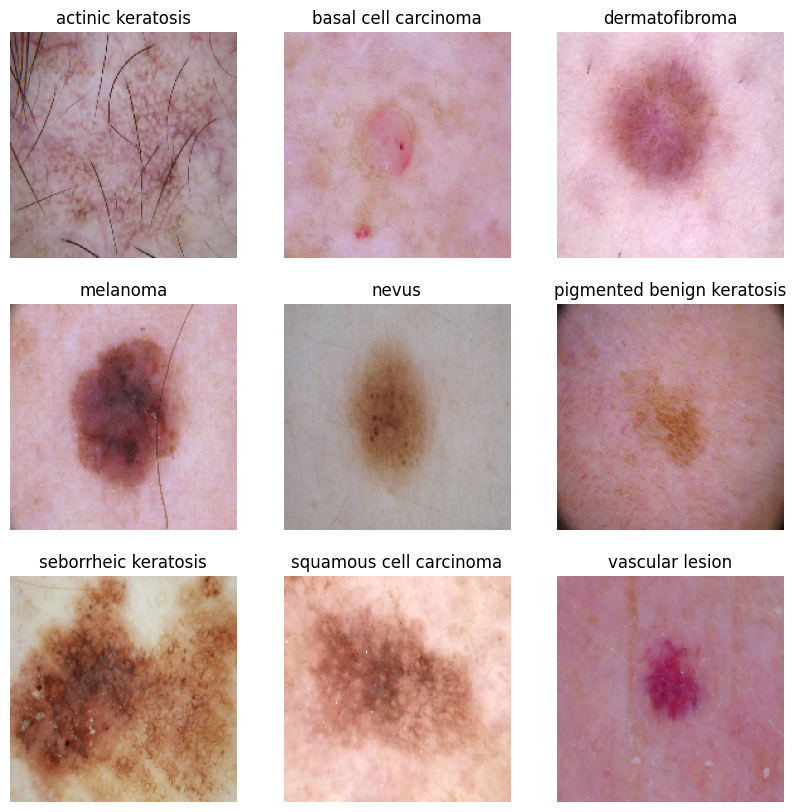

In [40]:


plt.figure(figsize=(10,10))
index = 0
for class_ in class_names:
    path = class_to_img_dict[class_][0]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path,target_size=(180,180)))
    plt.title(class_)
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [42]:
#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())
#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

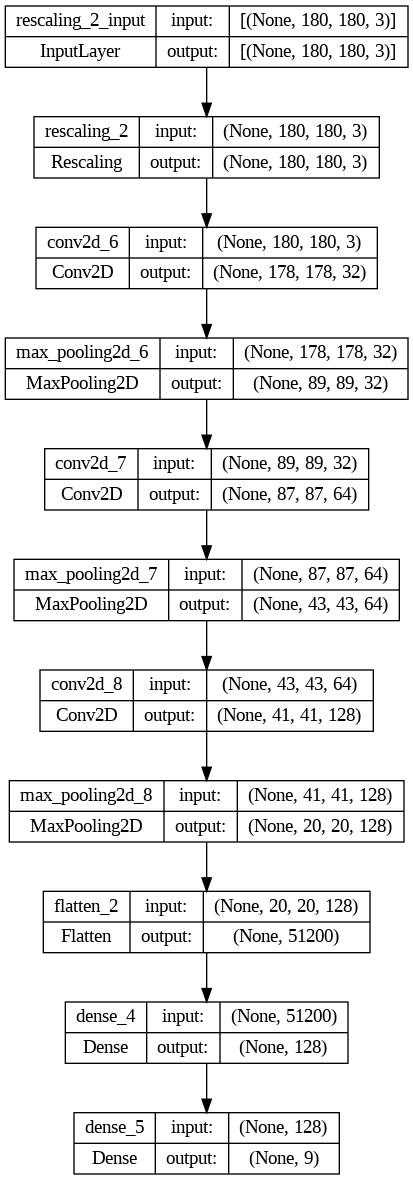

In [43]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [44]:
###  choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

### Train the model

In [46]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
210/210 [==============================] - 55s 50ms/step - loss: 1.7154 - accuracy: 0.3322 - val_loss: 5.7551 - val_accuracy: 0.0000e+00
Epoch 2/20
210/210 [==============================] - 7s 32ms/step - loss: 1.2885 - accuracy: 0.5036 - val_loss: 7.6093 - val_accuracy: 0.0000e+00
Epoch 3/20
210/210 [==============================] - 7s 32ms/step - loss: 1.0895 - accuracy: 0.5850 - val_loss: 8.9669 - val_accuracy: 0.0000e+00
Epoch 4/20
210/210 [==============================] - 7s 31ms/step - loss: 0.9056 - accuracy: 0.6589 - val_loss: 8.4885 - val_accuracy: 0.0000e+00
Epoch 5/20
210/210 [==============================] - 7s 32ms/step - loss: 0.7064 - accuracy: 0.7404 - val_loss: 9.6356 - val_accuracy: 0.0000e+00
Epoch 6/20
210/210 [==============================] - 7s 32ms/step - loss: 0.5027 - accuracy: 0.8162 - val_loss: 13.2168 - val_accuracy: 0.0000e+00
Epoch 7/20
210/210 [==============================] - 7s 34ms/step - loss: 0.4165 - accuracy: 0.8526 - val_loss: 12.

### Visualizing training results

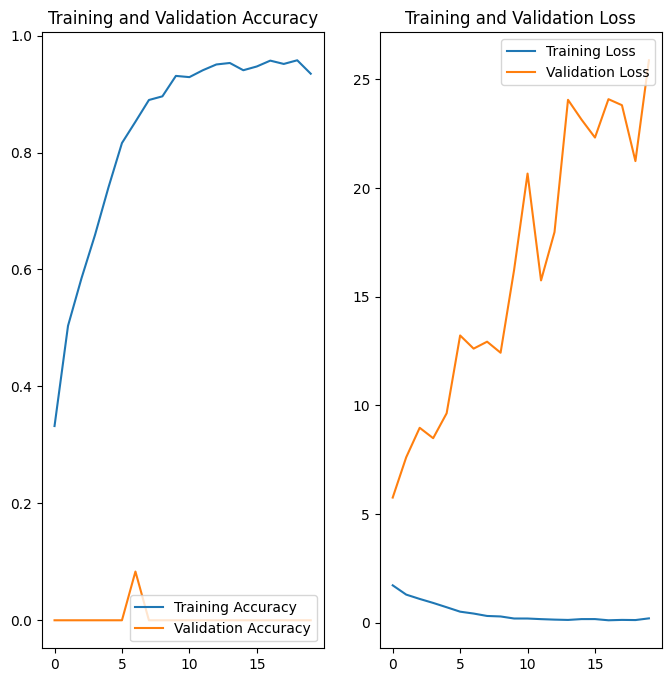

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### findings after the model fit, see if there is an evidence of model overfit or underfit



   
1.  The validation accuracy is zero
2.  dataset is not balanced across different classes. If one class has significantly fewer samples than others, the model may have difficulty learning from it.




In [18]:
#install Augmentor
!pip install Augmentor

In [23]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EB7B08186A0>: 100%|██████████| 500/500 [00:18<00:00, 26.91 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EB7900B0700>: 100%|██████████| 500/500 [00:17<00:00, 28.04 Samples/s]


Initialised with 190 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EB72EF460B0>: 100%|██████████| 500/500 [00:18<00:00, 27.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EB72EF50D90>: 100%|██████████| 500/500 [01:17<00:00,  6.49 Samples/s]


Initialised with 221 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EB72A613CD0>: 100%|██████████| 500/500 [01:47<00:00,  4.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EB79015DE40>: 100%|██████████| 500/500 [00:17<00:00, 28.99 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EB79015F7F0>: 100%|██████████| 500/500 [00:39<00:00, 12.66 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EB790077A30>: 100%|██████████| 500/500 [00:17<00:00, 29.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin_cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EB7901BB7F0>: 100%|██████████| 500/500 [00:19<00:00, 26.03 Samples/s]


In [24]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()


### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)


# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))


#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



Found 6698 files belonging to 9 classes.
Using 5359 files for training.
Found 6698 files belonging to 9 classes.
Using 1339 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                   

### Compiling the model

In [27]:
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
168/168 [==============================] - 60s 130ms/step - loss: 2.0098 - accuracy: 0.2374 - val_loss: 1.6084 - val_accuracy: 0.3682
Epoch 2/20
168/168 [==============================] - 9s 53ms/step - loss: 1.5321 - accuracy: 0.4135 - val_loss: 1.2713 - val_accuracy: 0.4974
Epoch 3/20
168/168 [==============================] - 9s 52ms/step - loss: 1.3335 - accuracy: 0.4900 - val_loss: 1.1193 - val_accuracy: 0.5586
Epoch 4/20
168/168 [==============================] - 9s 53ms/step - loss: 1.1841 - accuracy: 0.5473 - val_loss: 1.1912 - val_accuracy: 0.5347
Epoch 5/20
168/168 [==============================] - 9s 53ms/step - loss: 1.0820 - accuracy: 0.5934 - val_loss: 1.0669 - val_accuracy: 0.6288
Epoch 6/20
168/168 [==============================] - 9s 53ms/step - loss: 0.9592 - accuracy: 0.6363 - val_loss: 0.8722 - val_accuracy: 0.6923
Epoch 7/20
168/168 [==============================] - 9s 53ms/step - loss: 0.8283 - accuracy: 0.6873 - val_loss: 0.7485 - val_accuracy: 0.70

### Visualizing the results

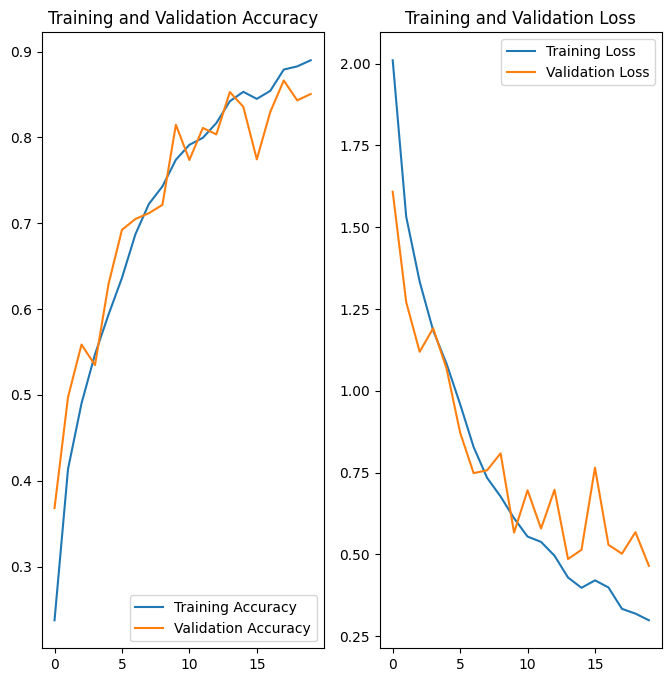

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**These were the original classes and no. of images:**
actinic keratosis - 114
basal cell carcinoma  - 376
dermatofibroma - 190
melanoma - 438
nevus - 221
pigmented benign keratosis - 462
seborrheic keratosis - 77
squamous cell carcinoma - 181
vascular lesion - 139

**There was a class imbalance issue which was solved using augmentor**. It involves applying various transformations to the original
training data to create new, slightly modified versions of the input samples. The goal of data augmentation is to increase the diversity
and quantity of training data. In this case ti was increased to 500

1. Both Training and validation accuracies are high
2. We can see in the graph, model is improving with additional training epochs
3. There is no significant gap between the training and validation curves, hence it does not suggests overfitting
4. The validation data curve is almost at par with training, which does not indicate overfitting

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples? pigmented benign keratosis
